# Preparation

In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [185]:
import os
from dotenv import load_dotenv
from typing import List
from copy import deepcopy
import numpy as np

# +++ ODEA +++
from odea.abstraction.concept import Concept
from odea.abstraction.mapping import Mapping

from odea.abstraction import metrics as m
from odea.abstraction.helper import metrics as m_helper
from odea.abstraction.helper import abstraction as abs_helper

from odea.io.sparql import SparQLConnector
from odea.io import event_log_helper as helper

# +++ Plots +++

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

# +++ PM4Py +++
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

Import Log and low-level concepts

In [6]:
log_file = '../data/Claim_handeling_v2_filtered.xes'
mapping_file = '../data/claim_event_mapping.csv'

event_to_con_mapping = helper.import_mapping(mapping_file)

ll_concepts: List[Concept]
ll_concepts = helper.concepts_from_log(log_file, mapping_file)

Configure SparQL Wrapper

In [7]:
load_dotenv()

SPARQL_ENDPOINT = os.getenv('SPARQL_ENDPOINT')
SPARQL_PREFIX = os.getenv('SPARQL_PREFIX')

connector = SparQLConnector(SPARQL_ENDPOINT, SPARQL_PREFIX)

Prepare low-level concepts

In [8]:
c: Concept

for idx, c in enumerate(ll_concepts):
    c.set_supertypes(connector.get_supertypes(c))
    c.set_subtypes(connector.get_subtypes(c))
    c.set_parents(connector.get_parents(c))
    c.set_children(connector.get_children(c))

# Compute Metrics

## Local

Granularity

In [9]:
agg = m_helper.get_max

In [10]:
leaf_paths = abs_helper.get_leaf_paths(connector)

In [11]:
for concept in ll_concepts:
    paths = abs_helper.find_path_to(concept, Concept('Task'), connector)
    concept.granularity = m.granularity(paths, leaf_paths, agg)   

Distance

In [12]:
mappings = abs_helper.find_abstraction_candidates(ll_concepts, connector)

In [13]:
for mapping in mappings:
    mapping.evaluation['dist'] = m.dist(mapping, agg)
    mapping.evaluation['rdist'] = m.rdist(mapping, agg)

## Regional

Support and Support by Frequency

In [14]:
for mapping in mappings:
    hl_con = mapping.target
    hl_con.supp = m.support(hl_con, mappings)
    hl_con.supp_freq = m.supp_by_freq(hl_con, mappings)

Expressiveness

In [15]:
for mapping in mappings:
    hl_con = mapping.target
    hl_con.set_subtypes(connector.get_subtypes(hl_con))
    hl_con.expr = m.expr(hl_con)

### Plot Support vs. Support by Frequency

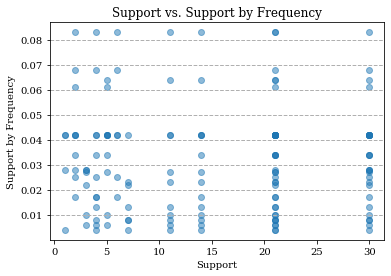

In [16]:
x = [mapping.target.supp for mapping in mappings]
y = [mapping.target.supp_freq for mapping in mappings]

# Plot
plt.scatter(x, y, alpha=0.5)
plt.title('Support vs. Support by Frequency')
plt.xlabel('Support')
plt.ylabel('Support by Frequency')
plt.grid('on', axis='y', linestyle='--', linewidth=1)
#plt.savefig("support_vs_supp_freq_serif.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Plot Support vs. Expressiveness

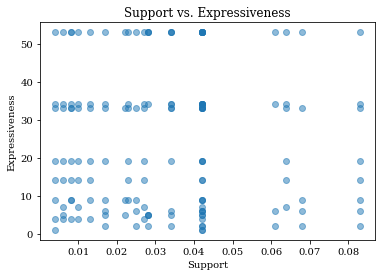

In [17]:
x = [mapping.target.supp_freq for mapping in mappings]
y = [mapping.target.expr for mapping in mappings]

# Plot
plt.scatter(x, y, alpha=0.5)
plt.title('Support vs. Expressiveness')
plt.xlabel('Support')
plt.ylabel('Expressiveness')
plt.show()

## Global

Complextiy Reduction

In [18]:
ca = m_helper.get_abstraction_goals(mappings)
cla = m_helper.get_abstractable_concepts(mappings)
cl = m_helper.get_low_level_concepts(ll_concepts)
clna = m_helper.get_not_abstractable_concepts(ll_concepts, mappings)

In [19]:
cr = m.complexity_reduction(ca, cla)
print(cr)

0.742


Total Complexity Reducion

In [20]:
ctr = m.complexity_reduction_total(ca, clna, cl)
print(ctr)

0.233


# Contraints

## Support

Try different configurations for support contraints:

In [21]:
mappings2 = deepcopy(mappings)
len(mappings2)

supp = range(0, 25, 5)
result = []

for s in supp:
    filtered_mapping = abs_helper.filter_abstraction_candidates(mappings2, 100, s)
    #print(len(filtered_mapping))

    ca = m_helper.get_abstraction_goals(filtered_mapping)
    cla = m_helper.get_abstractable_concepts(filtered_mapping)
    cl = m_helper.get_low_level_concepts(ll_concepts)
    clna = m_helper.get_not_abstractable_concepts(ll_concepts, filtered_mapping)

    cr = m.complexity_reduction(ca, cla)
    ctr = m.complexity_reduction_total(ca, clna, cl)

    result.append((cr, ctr, len(ca)))
        
print(result)

[(0.742, 0.233, 23), (0.226, 0.767, 7), (0.161, 0.833, 5), (0.097, 0.9, 3), (0.097, 0.9, 3)]


## Dist

## Support & Dist

In [22]:
mappings2 = deepcopy(mappings)

rdist = []
supp = []
for mapping in mappings2:
    rdist.append(mapping.evaluation['dist'])
    supp.append(mapping.target.supp)

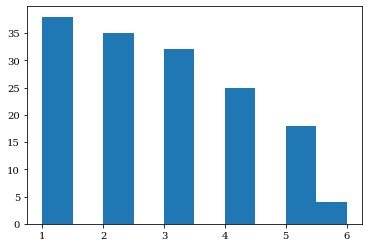

In [23]:
plt.hist(rdist)
plt.show()

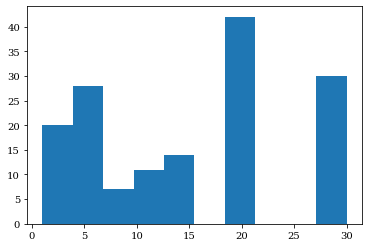

In [24]:
plt.hist(supp)
plt.show()

In [25]:
mappings2 = deepcopy(mappings)
len(mappings2)

dist = range(1, 4, 1)
#rel_dist = np.linspace(0.1,0.9,10)
supp = range(0, 25, 1)
#supp_freq = np.linspace(0,0.1,20)
result = []

leaf_paths = abs_helper.get_leaf_paths(connector)

for d in dist:
    for s in supp:
        filtered_mappings = abs_helper.filter_abstraction_candidates(mappings2, d, s)
        
        chosen_mappings = abs_helper.select_mapping(filtered_mappings, connector, leaf_paths)
        
        ca = m_helper.get_abstraction_goals(chosen_mappings)
        cla = m_helper.get_abstractable_concepts(chosen_mappings)
        cl = m_helper.get_low_level_concepts(ll_concepts)
        clna = m_helper.get_not_abstractable_concepts(ll_concepts, chosen_mappings)
        
        cr = m.complexity_reduction(ca, cla)
        ctr = m.complexity_reduction_total(ca, clna, cl)
        
        result.append((cr, ctr, len(ca), d, s))
        
#print(result)

In [208]:
re = list(filter(lambda r: r[2] == 4, result))

#re = result

print('{:<3s} | {:^5s} | {:^5s} | {:^3s} | {:^4s} | {:^6s} |'.format('', 'cr', 'tcr', 'Ca', 'd', 's'))
print('-------------------------------------------')
for i, r in enumerate(re):
    print('{:<3d} | {:.3f} | {:.3f} | {:^3d} | {:^3.2f} | {:^6.2f} |'.format(i+1, r[0], r[1], r[2], r[3], r[4]))

    |  cr   |  tcr  | Ca  |  d   |   s    |
-------------------------------------------
1   | 0.571 | 0.067 |  4  | 1.00 |  6.00  |
2   | 0.267 | 0.333 |  4  | 2.00 | 11.00  |
3   | 0.267 | 0.333 |  4  | 2.00 | 12.00  |
4   | 0.267 | 0.333 |  4  | 2.00 | 13.00  |
5   | 0.160 | 0.667 |  4  | 3.00 | 11.00  |
6   | 0.160 | 0.667 |  4  | 3.00 | 12.00  |
7   | 0.160 | 0.667 |  4  | 3.00 | 13.00  |


### Visualization

In [90]:
s = []

for r in result:
    s.append((r[0], r[2]))

len(set(s))

28

In [27]:
from matplotlib.ticker import FormatStrFormatter

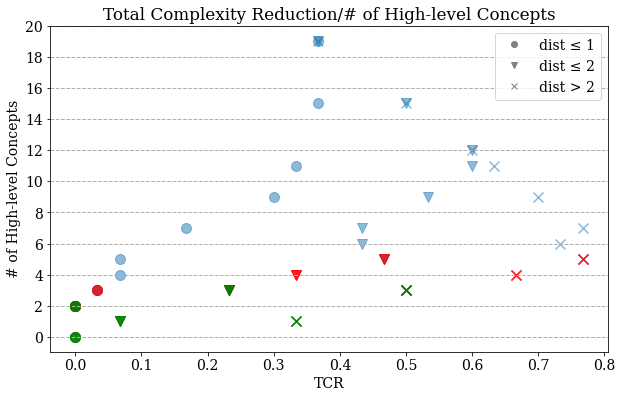

In [234]:
marker = ['o', 'v', 'x']
colors = ['#1f77b4', 'red', 'green']

points = [
    (1,1, 1, 1),
    (2,2, 1, 2),
    (3,3, 1, 4),
    (4,4, 2, 4),
    (5,5, 2, 6),
    (6,6, 3, 7),
    (7,7, 3, 8),
    (8,8, 3, 12)
]


#plt.figure(figsize=(10,6))
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

for res in result:
    # distance
    if res[3] <= 1:
        ma = 0
        ml = 'dist ≤ 1'
    elif res[3] <= 2:
        ma = 1
        ml = 'dist ≤ 2'
    else:
        ma = 2
        ml = 'dist > 2'
    
    # support
    if res[4] <= 8:
        c = 0
        cl = 'supp ≤ 8'
        
    elif res[4] <= 16:
        c = 1
        cl = 'supp ≤ 16'
    else:
        c = 2
        cl = 'supp > 16'
    
    
    l = str(ml) + "; " + str(cl)
        
    ax.scatter(res[1], res[2], s=100, marker=marker[ma], color=colors[c], label=l, alpha=0.5)
    

plt.title('Total Complexity Reduction/# of High-level Concepts')
plt.xlabel('TCR')
plt.ylabel('# of High-level Concepts')
ax.set_yticks(range(0, 22, 2))
plt.grid('on', axis='y', linestyle='--', linewidth=1)
#legend_without_duplicate_labels(ax)

# ============
triangleArtist = plt.Line2D((0,0),(0,0), color='gray', marker='o',linestyle='')
dotArtist = plt.Line2D((0,0),(0,0), color='gray', marker='v',linestyle='')
crossArtist = plt.Line2D((0,0),(0,0), color='gray', marker='x', linestyle='')

#Create legend from custom artist/label lists
ax.legend([triangleArtist,dotArtist,crossArtist],
          ['dist ≤ 1','dist ≤ 2','dist > 2'])

# ============

#plt.savefig("scenario_1_tcr_over_ca_dist_and_supp_serif.svg", format="svg", bbox_inches="tight")
plt.show()

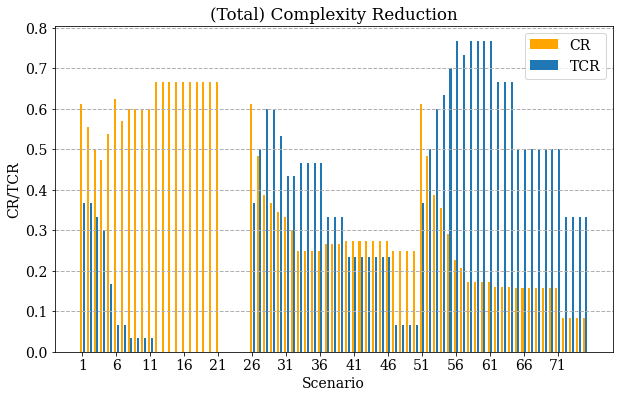

In [175]:
# create data
plt.figure(figsize=(10,6))
width = 0.30

scenario = range(1, len(result) + 1)
cr = [res[0] for res in result]
tcr = [res[1] for res in result]
x = np.arange(1, len(scenario)+1)
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, cr, width, color='orange', label='CR')
plt.bar(x+0.2, tcr, width, label='TCR')

plt.title('(Total) Complexity Reduction')
plt.xlabel('Scenario')
plt.ylabel('CR/TCR')
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.25), ncol=2)
plt.legend()
plt.xticks(range(1, len(scenario), 5))
plt.grid('on', axis='y', linestyle='--', linewidth=1)
#plt.savefig("scenario_bar_1_3_24_serif.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [40]:
result[11]

(0.613, 0.367, 19, 2, 0.0)

### Discovery

In [229]:
mappings2 = deepcopy(mappings)
len(mappings2)

dist = 1
supp = 6

leaf_paths = abs_helper.get_leaf_paths(connector)

filtered_mappings = abs_helper.filter_abstraction_candidates(mappings2, dist, supp)

chosen_mappings = abs_helper.select_mapping(filtered_mappings, connector, leaf_paths)

ca = m_helper.get_abstraction_goals(chosen_mappings)
cla = m_helper.get_abstractable_concepts(chosen_mappings)
cl = m_helper.get_low_level_concepts(ll_concepts)
clna = m_helper.get_not_abstractable_concepts(ll_concepts, chosen_mappings)

cr = m.complexity_reduction(ca, cla)
ctr = m.complexity_reduction_total(ca, clna, cl)

print(cr, ctr, len(cla), len(chosen_mappings))

0.571 0.067 6 6


In [ ]:
['Processing_Task', 'External_Communication', 'Administrative_Task', 'Decision_Task']
['Processing_Task', 'Communication_Task', 'Task', 'Administrative_Task']

In [223]:
for kk in chosen_mappings:
    print(kk)

Information_Request -> External_Communication
	- dist           : 1
	- rdist          : 0.2
Decision_Task -> Processing_Task
	- dist           : 1
	- rdist          : 0.333333
Archive -> Administrative_Task
	- dist           : 1
	- rdist          : 0.333333
External_Review -> External_Communication
	- dist           : 1
	- rdist          : 0.2
Grant_Transaction -> Decision_Task
	- dist           : 1
	- rdist          : 0.25
Reject_Claim -> Decision_Task
	- dist           : 1
	- rdist          : 0.25


2;1

In [210]:
ll1 = []
hl1 = []
for ma in mappings:
    ll1.append(ma.source.label)
    hl1.append(ma.target.label)

ll1 = set(ll1)
hl1 = set(hl1)

In [212]:
print(hl1)

{'Structural_Assessment', 'Digitalization_Task', 'External_Communication', 'Information_Processessing', 'Communication_Task', 'Information_Request', 'Information_Acquisition_Task', 'Personal_Review', 'Archive', 'Extended_Review', 'Administrative_Task', 'Task', 'Accounting_Task', 'Decision_Task', 'Internal_Communication', 'Customer_Management_Task', 'Processing_Task', 'Booking', 'Allocation_Task', 'Assessment_Task', 'Third_Party_Information_Request', 'Document_Management', 'Factual_Assessment'}


3;1

In [200]:
ll2 = []
hl2 = []
for ma in mappings:
    ll2.append(ma.source.label)
    hl2.append(ma.target.label)

ll2 = set(ll2)
hl2 = set(hl2)

In [202]:
hl1 == hl2

True

In [ ]:
0.484 0.5

#### Replace Events in Log based in Mappings

In [31]:
log = xes_importer.apply(log_file)

In [39]:
new_log = helper.enhance_event_labels(log, event_to_con_mapping, chosen_mappings)

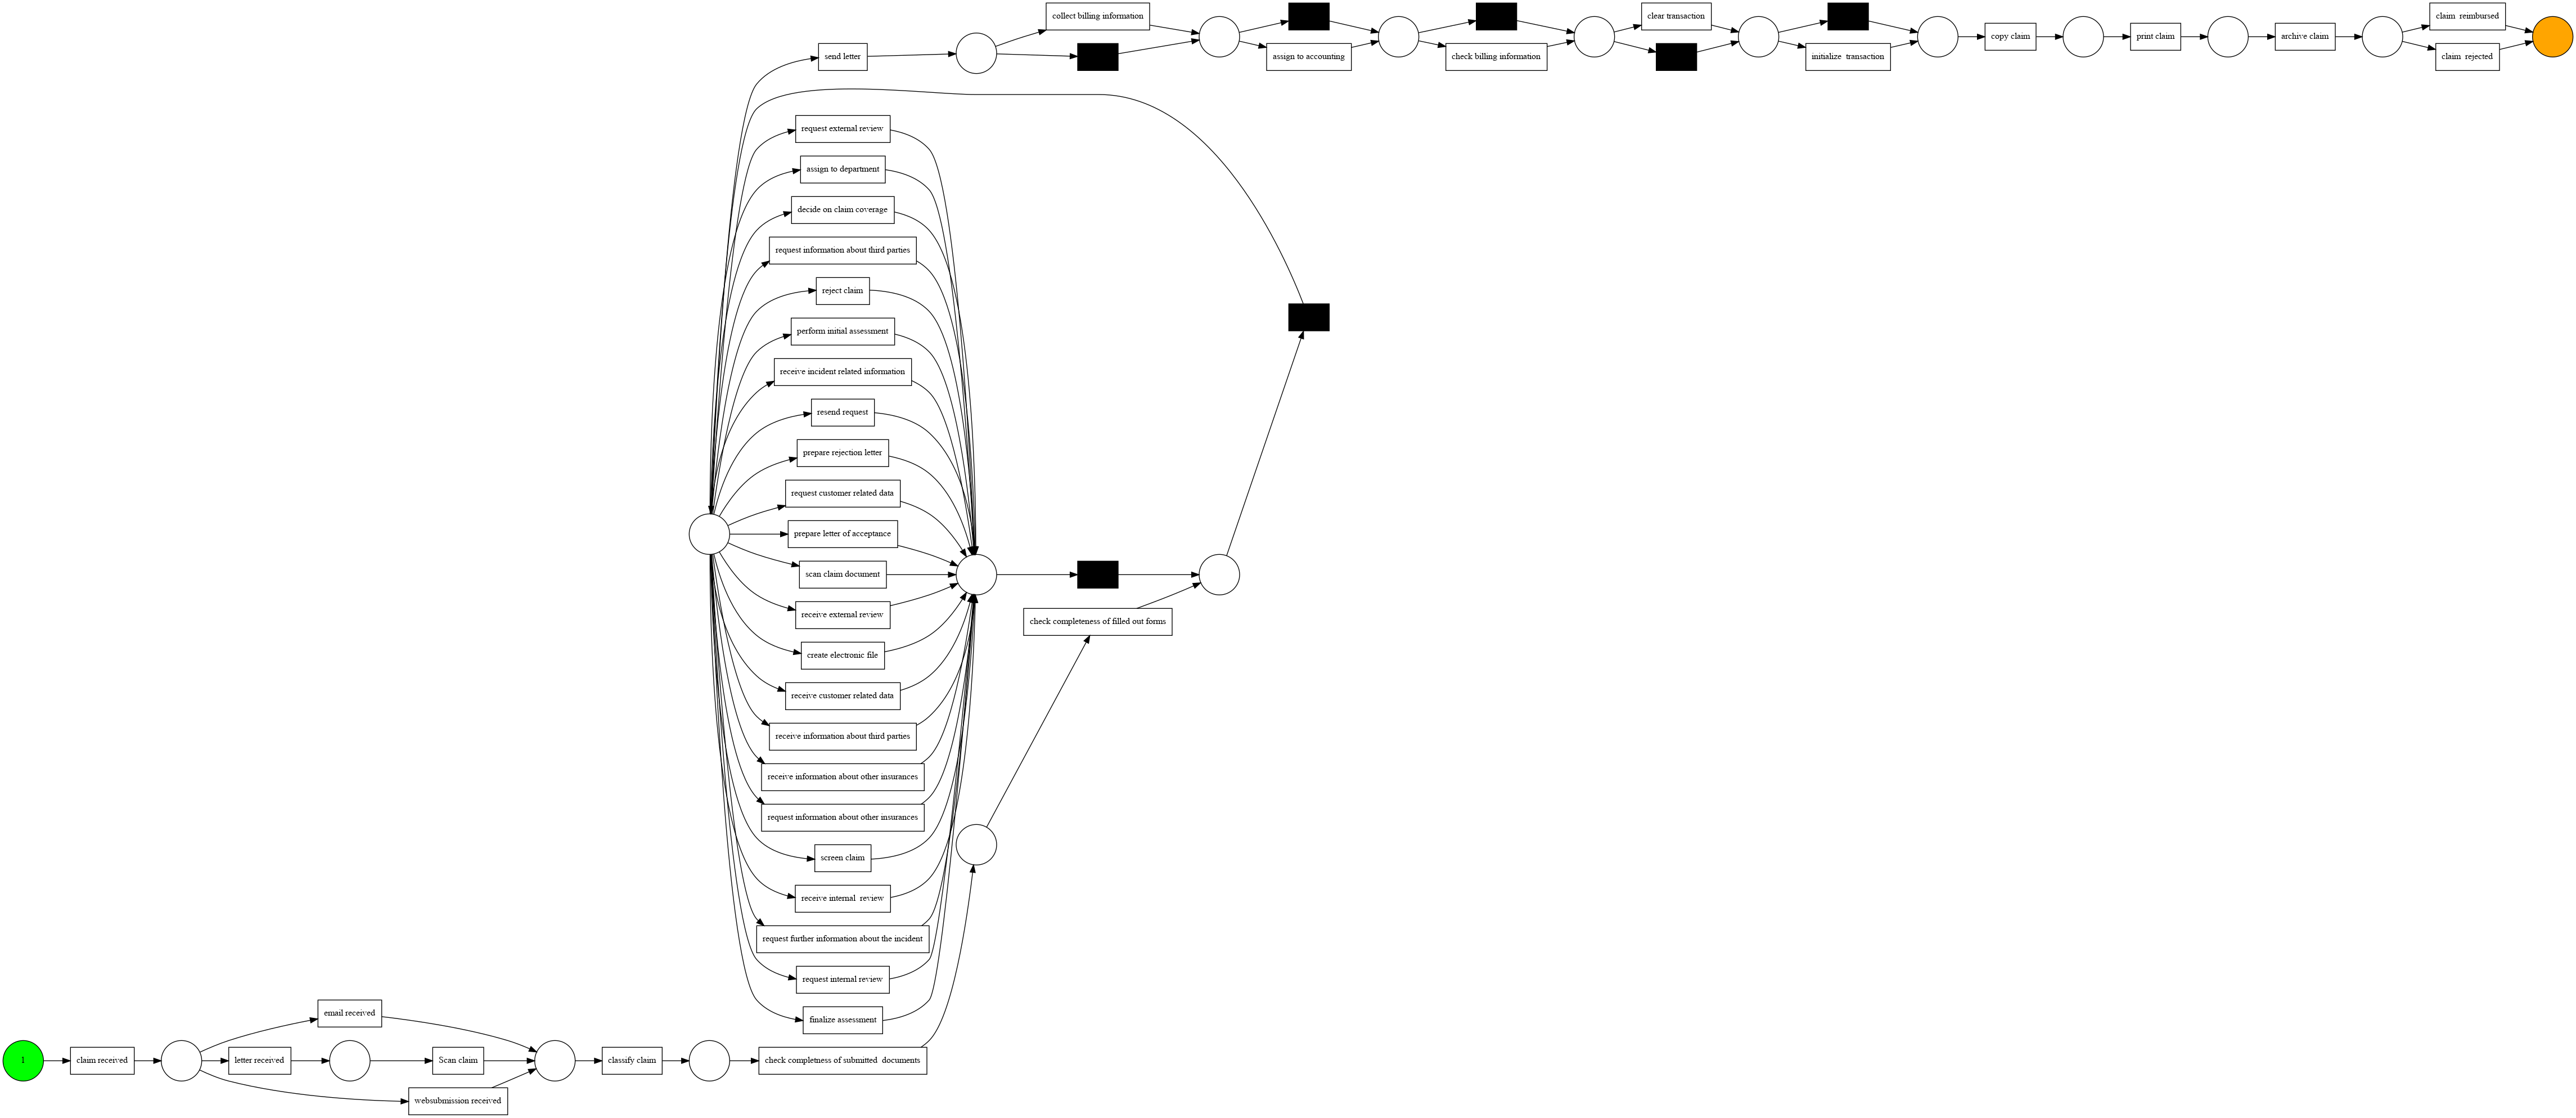

In [33]:
net, initial_marking, final_marking = inductive_miner.apply(log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

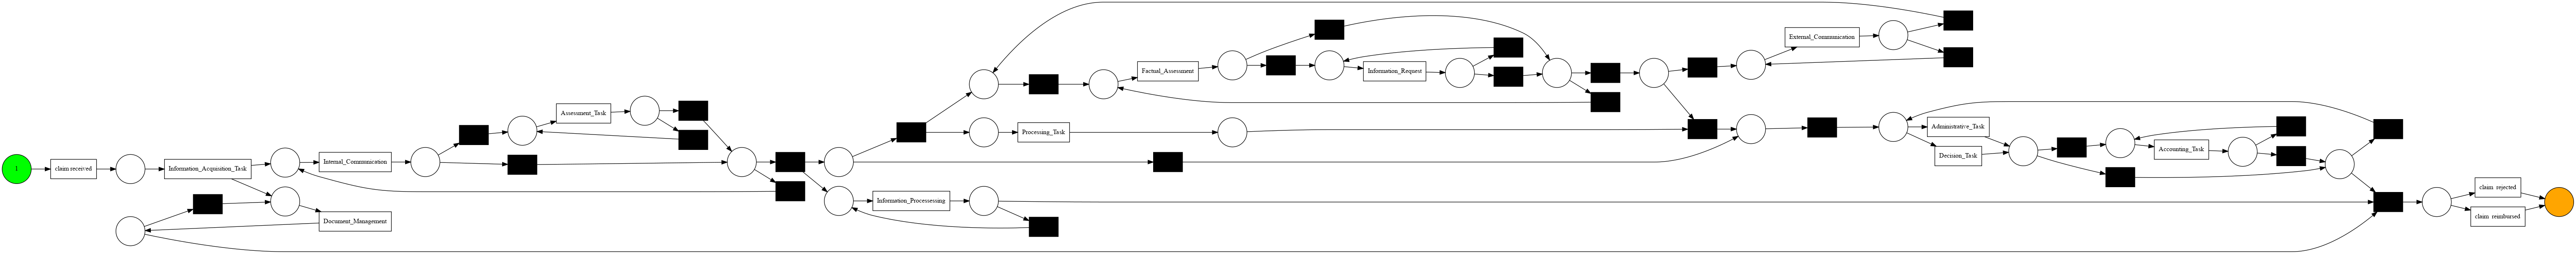

In [40]:
net, initial_marking, final_marking = inductive_miner.apply(new_log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [47]:
import pm4py
from pm4py.objects.conversion.process_tree import converter
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer

In [42]:
tree = pm4py.discover_process_tree_inductive(new_log)

In [44]:
bpmn_graph = converter.apply(tree, variant=converter.Variants.TO_BPMN)

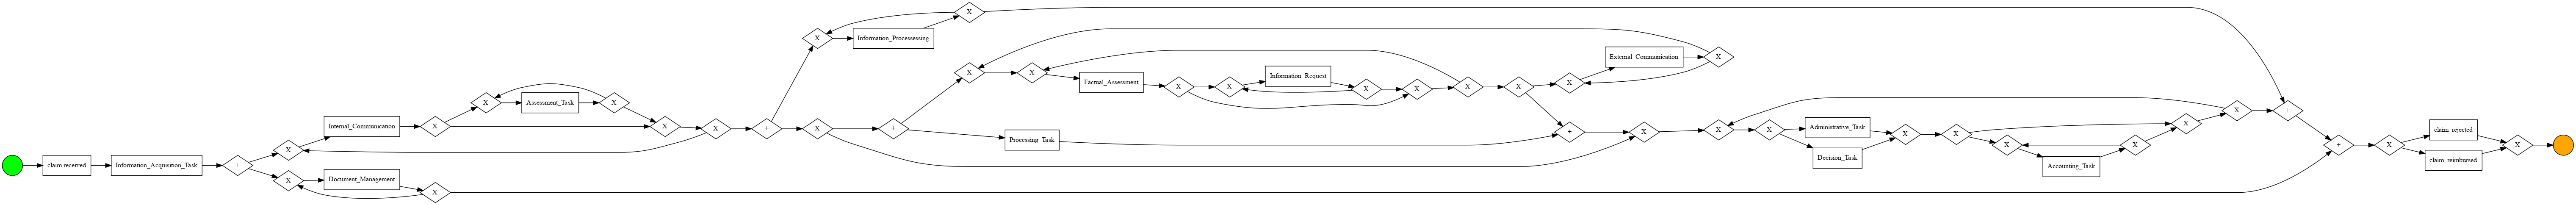

In [50]:
gviz = bpmn_visualizer.apply(bpmn_graph)
bpmn_visualizer.view(gviz)